#**Paper for my Concept and Model:-https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf**

#**Imports :**

In [130]:
import os
import glob
import cv2
import torch
import random
import shutil
import zipfile
import torchinfo
import numpy as np
import pandas as pd
from torch import nn
from PIL import Image
import pathlib as Path
from tqdm.auto import tqdm
from torchinfo import summary
from typing import Dict, List
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
from torchvision import datasets,transforms
from torch.utils.data import TensorDataset,ConcatDataset,DataLoader,random_split

###Setting up device Agnostic Code:
PyTorch does not provide a specific setting to control GPU memory growth like TensorFlow does. Instead, it allocates GPU memory dynamically and incrementally as needed during runtime.

In [131]:
device="cuda" if torch.cuda.is_available() else "cpu"

###Create Data Folder Structure

In [132]:
pos_path=os.path.join("data","positive")
neg_path=os.path.join("data","negative")
anc_path=os.path.join("data","anchor")
os.makedirs(pos_path,exist_ok=True)
os.makedirs(neg_path,exist_ok=True)
os.makedirs(anc_path,exist_ok=True)

#**DataSet and Preprocessing :**

###Unpack labelled Faces in the wild Dataset

###Move All the images from the Folders outside folders and delete all those extra folders  

In [12]:
import os
import shutil
from pathlib import Path

# Paths
dataset_folder = Path("./Facial_Dataset/lfw-deepfunneled") 
negative_folder = Path("./data/negative")

# Walk through all subfolders and move images
count = 0
for root, dirs, files in os.walk(dataset_folder):
    for file in files:
        if file.lower().endswith(".jpg"):
            src_path = Path(root) / file
            dest_path = negative_folder / file
            shutil.move(str(src_path), str(dest_path))
            count += 1

print(f"Moved {count} images to {negative_folder}")


Moved 13233 images to data\negative


###Collecting Images for our Postive and Anchor Folder using OpenCV

In [133]:
#(frame[120:120+250,200:200+250,:]).shape for Making the dimension of the web cam same as our training negative images dimensions:

In [134]:
#Importing uuid for generating unique image names:
import uuid

In [6]:
#Establish Connection to our webCam:
cap=cv2.VideoCapture(0)
while cap.isOpened():
  ret,frame=cap.read()
    
  #to bring the frame to 250*250 pixels as our Training images
  frame=frame[120:120+250,200:200+250,:]

  #Collect for Anchor:
  if cv2.waitKey(1) & 0XFF ==ord ('a'):
      #creating path for our image that is going to be stored:
      imgname=os.path.join(anc_path,'{}.jpg'.format(uuid.uuid1()))
      #saving the image into our anchor folder:
      cv2.imwrite(imgname,frame)

  #Collect for Positive:
  if cv2.waitKey(1) & 0XFF ==ord ('p'):
      #creating path for our image that is going to be stored:
      imgname=os.path.join(pos_path,'{}.jpg'.format(uuid.uuid1()))
      #saving the image into our positive folder:
      cv2.imwrite(imgname,frame)
    
    
  #showing image back to screen:
  cv2.imshow('Image Collection',frame)

  if cv2.waitKey(1) & 0XFF ==ord ('q'):
    break
      
#Release the web Cam:
cap.release()
#Close the image show frameq
cv2.destroyAllWindows()

###If we got error: src.empty() in function 'cv::cvtColor' or no error still the pop up will not come this means not the right webcam number.

(250, 250, 3)


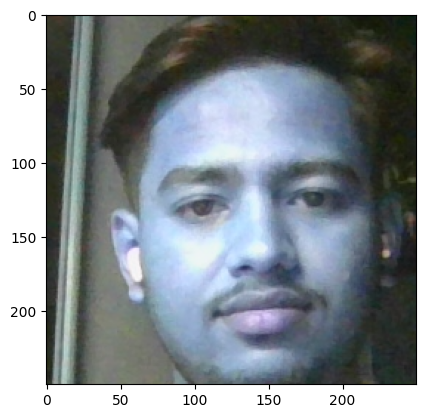

In [25]:
plt.imshow(frame)
print(frame.shape)

**Visualize...Visualize...Visualize... And PreProcessing**

In [58]:
#Image Directories Path:

(np.float64(-0.5), np.float64(249.5), np.float64(249.5), np.float64(-0.5))

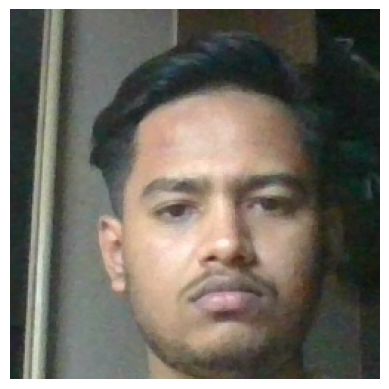

In [135]:
anchor_images=glob.glob(f"{anc_path}/*.jpg")[:300]  #path to anchor images inside the data/anchor folder..
positive_images=glob.glob(f"{pos_path}/*.jpg")[:300] #same
negative_images=glob.glob(f"{neg_path}/*.jpg")[:300] #same

img=next(iter(anchor_images))
image=Image.open(img)
plt.imshow(image)
plt.axis("off")

In [136]:
#Transforming Images:

In [137]:
Image_transform=transforms.Compose([
    transforms.Resize(size=(105,105)),
    transforms.ToTensor()
])
transformed_image=Image_transform(image)
print(transformed_image.shape)
print(transformed_image.dtype)

torch.Size([3, 105, 105])
torch.float32


In [138]:
#Creating The Labelled Dataset:
#(anchor,positive):{1,1,1,1,1,1..}
#(anchor.negative):{0,0,0,0,0...}

# take 300 anchor images,
# Pair each with a positive image (same class/label), labeled 1,
# And pair each with a negative image (different class/label), labeled 0.

# Then you create two datasets:
# One with all those (anchor, positive, label=1) pairs,
# Another with all (anchor, negative, label=0) pairs.

# Finally, you concatenate these two datasets into one combined dataset of size 600 (300 positives + 300 negatives).
# This combined dataset can then be used for training your Siamese network with contrastive or
# binary cross-entropy loss to teach the model to bring positive pairs closer in embedding space and push negative pairs apart.

In [139]:
def load_images(image_paths):
    tensors = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        img = Image_transform(img)
        tensors.append(img)
    return torch.stack(tensors)

# Load and convert all sets
anchor_images = load_images(anchor_images)
positive_images = load_images(positive_images)
negative_images = load_images(negative_images)

# Labels
pos_labels = torch.ones(len(anchor_images), dtype=torch.float32)
neg_labels = torch.zeros(len(anchor_images), dtype=torch.float32)

# Create datasets
Positives = TensorDataset(anchor_images, positive_images, pos_labels)
Negatives = TensorDataset(anchor_images, negative_images, neg_labels)

# Combine datasets
data = ConcatDataset([Positives, Negatives])
print(f"Total samples in dataset:{len(data)}")

Total samples in dataset:600


(tensor([[[0.2000, 0.1922, 0.1843,  ..., 0.0471, 0.0549, 0.0588],
         [0.1961, 0.1922, 0.1882,  ..., 0.0667, 0.0745, 0.0706],
         [0.1882, 0.1843, 0.1843,  ..., 0.0745, 0.0824, 0.0784],
         ...,
         [0.1020, 0.1333, 0.1765,  ..., 0.1647, 0.1765, 0.1686],
         [0.1020, 0.1216, 0.1686,  ..., 0.1569, 0.1725, 0.1765],
         [0.1137, 0.1216, 0.1647,  ..., 0.1529, 0.1529, 0.1647]],

        [[0.2118, 0.2157, 0.2196,  ..., 0.0902, 0.0941, 0.0941],
         [0.2118, 0.2157, 0.2235,  ..., 0.1020, 0.1020, 0.0941],
         [0.2157, 0.2157, 0.2235,  ..., 0.0980, 0.0980, 0.0863],
         ...,
         [0.1686, 0.1922, 0.2196,  ..., 0.1647, 0.1804, 0.1686],
         [0.1686, 0.1804, 0.2157,  ..., 0.1725, 0.1843, 0.1765],
         [0.1608, 0.1686, 0.2000,  ..., 0.1843, 0.1725, 0.1725]],

        [[0.2314, 0.2314, 0.2353,  ..., 0.0667, 0.0706, 0.0745],
         [0.2314, 0.2314, 0.2314,  ..., 0.0745, 0.0745, 0.0667],
         [0.2353, 0.2275, 0.2235,  ..., 0.0706, 0.0706, 0

(np.float64(-0.5), np.float64(104.5), np.float64(104.5), np.float64(-0.5))

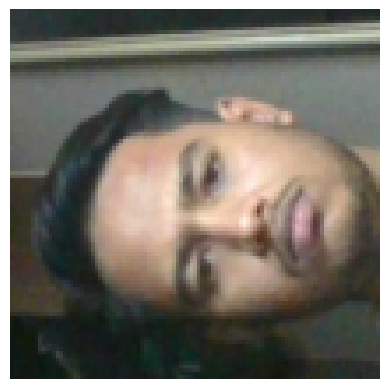

In [140]:
sample=next(iter(data))
img_sample=sample[0].permute(2,1,0)
print(sample)
plt.imshow(img_sample)
plt.axis("off")

In [141]:
#training and Testing DataLoader dataset:
datasize=len(data)
train_size=int(0.7*datasize)
test_size=datasize-train_size
train_dataset,test_dataset=random_split(data,[train_size,test_size])
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader=DataLoader(test_dataset,batch_size=16,shuffle=False)

print(f"Train Samples: {len(train_dataset)}")
print(f"Test Samples: {len(test_dataset)}")
print(f"Train Dataloader: {len(train_dataloader)} of size 16")
print(f"Test Dataloader: {len(test_dataloader)} of size 16")

Train Samples: 420
Test Samples: 180
Train Dataloader: 27 of size 16
Test Dataloader: 12 of size 16


**Model Enginnering:**

### The forward_once method is like a single pass through the network to get the embedding of one input.

### The forward method calls forward_once twice — once for each input — to get both embeddings.

### Then you can compare those two embeddings to measure similarity.



In [142]:
#Base Saimese Model:
class ModelSaimese(nn.Module):
    def __init__(self):
        super().__init__()
        self.Conv_Block=nn.Sequential(
            nn.Conv2d(in_channels=3,
                     out_channels=64,
                     kernel_size=10),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=64,
                      out_channels=128,
                      kernel_size=7),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(in_channels=128,
                      out_channels=128,
                      kernel_size=4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            
            nn.Conv2d(in_channels=128,
                      out_channels=256,
                      kernel_size=4),
            nn.ReLU(inplace=True),
        )

        self.Classifier=nn.Sequential(
            nn.Linear(in_features=256*6*6,
                     out_features=4096),
            nn.Sigmoid()
        )
        
    def forward_once(self,x):
        x=self.Conv_Block(x)
        x=x.view(x.size(0),-1) #nn.Flatten()
        x=self.Classifier(x)
        return x

    def forward(self,input1,input2):
        output1=self.forward_once(input1)
        output2=self.forward_once(input2)
        return output1,output2

model=ModelSaimese()
model

ModelSaimese(
  (Conv_Block): Sequential(
    (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU(inplace=True)
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU(inplace=True)
  )
  (Classifier): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
)

In [143]:
summary(model, input_data=(torch.randn(1,3,105,105), torch.randn(1,3,105,105)))

Layer (type:depth-idx)                   Output Shape              Param #
ModelSaimese                             [1, 4096]                 --
├─Sequential: 1-1                        [1, 256, 6, 6]            --
│    └─Conv2d: 2-1                       [1, 64, 96, 96]           19,264
│    └─ReLU: 2-2                         [1, 64, 96, 96]           --
│    └─MaxPool2d: 2-3                    [1, 64, 48, 48]           --
│    └─Conv2d: 2-4                       [1, 128, 42, 42]          401,536
│    └─ReLU: 2-5                         [1, 128, 42, 42]          --
│    └─MaxPool2d: 2-6                    [1, 128, 21, 21]          --
│    └─Conv2d: 2-7                       [1, 128, 18, 18]          262,272
│    └─ReLU: 2-8                         [1, 128, 18, 18]          --
│    └─MaxPool2d: 2-9                    [1, 128, 9, 9]            --
│    └─Conv2d: 2-10                      [1, 256, 6, 6]            524,544
│    └─ReLU: 2-11                        [1, 256, 6, 6]           

In [144]:
#Custom L1Distance Calculator Class: (Specially For Saimese Neural Network)
class L1Dist(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, input_embedding, validation_embedding):
        return torch.abs(input_embedding - validation_embedding)

l1=L1Dist()

In [145]:
#Combining Base Model and L1Dist Class:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.base_model = ModelSaimese()
        self.l1_distance = L1Dist()
        self.classifier = nn.Sequential(
            nn.Linear(in_features=4096,
                      out_features=1), 
            nn.Sigmoid()
        )
    
    def forward(self, input1, input2):
        output1 = self.base_model.forward_once(input1)
        output2 = self.base_model.forward_once(input2)
        l1_dist = self.l1_distance(output1, output2)
        out= self.classifier(l1_dist)
        return out

In [146]:
Model_0=SiameseNetwork()
Model_0

SiameseNetwork(
  (base_model): ModelSaimese(
    (Conv_Block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (10): ReLU(inplace=True)
    )
    (Classifier): Sequential(
      (0): Linear(in_features=9216, out_features=4096, bias=True)
      (1): Sigmoid()
    )
  )
  (l1_distance): L1Dist()
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [147]:
summary(Model_0,input_data=(torch.randn(1,3,105,105), torch.randn(1,3,105,105)))

Layer (type:depth-idx)                   Output Shape              Param #
SiameseNetwork                           [1, 1]                    --
├─ModelSaimese: 1-1                      --                        --
│    └─Sequential: 2-1                   [1, 256, 6, 6]            --
│    │    └─Conv2d: 3-1                  [1, 64, 96, 96]           19,264
│    │    └─ReLU: 3-2                    [1, 64, 96, 96]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 48, 48]           --
│    │    └─Conv2d: 3-4                  [1, 128, 42, 42]          401,536
│    │    └─ReLU: 3-5                    [1, 128, 42, 42]          --
│    │    └─MaxPool2d: 3-6               [1, 128, 21, 21]          --
│    │    └─Conv2d: 3-7                  [1, 128, 18, 18]          262,272
│    │    └─ReLU: 3-8                    [1, 128, 18, 18]          --
│    │    └─MaxPool2d: 3-9               [1, 128, 9, 9]            --
│    │    └─Conv2d: 3-10                 [1, 256, 6, 6]            524,

## Loss function and Optimizer:

In [148]:
loss_fn=nn.BCELoss() 
optimizer=torch.optim.Adam(params=Model_0.parameters(),
                       lr=0.001)

## Training And Testing function:
loss.item() alone gives you the average loss per sample in the current batch.

Multiplying by input1.size(0) (the batch size) converts this average back into the total loss for the entire batch.

In [149]:
def Train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device):
    model.train()
    train_loss = 0
    train_acc = 0
    total_samples = 0

    for batch, (input1, input2, labels) in enumerate(dataloader):
        input1, input2, labels = input1.to(device), input2.to(device), labels.to(device).float()
        y_pred = model(input1, input2).squeeze()
        loss = loss_fn(y_pred, labels)
        train_loss += loss.item() * input1.size(0)  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = (y_pred >= 0.5).float()

        train_acc += (preds == labels).sum().item()
        total_samples += input1.size(0)

    avg_loss = train_loss / total_samples
    avg_acc = train_acc / total_samples

    return avg_loss, avg_acc


In [150]:
def Test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device):
    model.eval()
    test_loss = 0
    test_acc = 0
    total_samples = 0

    with torch.inference_mode():
        for batch, (input1, input2, labels) in enumerate(dataloader):
            input1, input2, labels = input1.to(device), input2.to(device), labels.to(device).float()
            y_pred = model(input1, input2).squeeze()
            loss = loss_fn(y_pred, labels)
            test_loss += loss.item() * input1.size(0)

            preds = (y_pred >= 0.5).float()
            test_acc += (preds == labels).sum().item()
            total_samples += input1.size(0)

    avg_loss = test_loss / total_samples
    avg_acc = test_acc / total_samples

    return avg_loss, avg_acc


In [151]:
def training(model:torch.nn.Module,
             train_dataloader:torch.utils.data.DataLoader,
             test_dataloader:torch.utils.data.DataLoader,
             optimizer:torch.optim.Optimizer,
             loss_fn:torch.nn.Module=nn.CrossEntropyLoss(),
             epochs=int,
             device=device):
  #creating empty Dictionary result:
  result={"train_loss": [],
          "train_accuracy": [],
          "test_loss": [],
          "test_accuracy": []}
  for epoch in tqdm(range(epochs)):
    average_train_loss,average_train_acc=Train_step(model=Model_0,
                                                    dataloader=train_dataloader,
                                                    loss_fn=loss_fn,
                                                    optimizer=optimizer,
                                                    device=device)
    average_test_loss,average_test_acc=Test_step(model=Model_0,
                                                 dataloader=test_dataloader,
                                                 loss_fn=loss_fn,
                                                 device=device)

    print(f"Epoch: {epoch} | Train loss: {average_train_loss:.4f} | Train accuracy: {average_train_acc:.4f} | Test loss: {average_test_loss:.4f} | Test Accuracy: {average_test_acc:.4f}")

    result["train_loss"].append(average_train_loss)
    result["train_accuracy"].append(average_train_acc)
    result["test_loss"].append(average_test_loss)
    result["test_accuracy"].append(average_test_acc)

  return result

In [152]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
num_epoch=6
model_0_result=training(model=Model_0,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=num_epoch,
                        device=device)

 17%|██████████████                                                                      | 1/6 [01:04<05:24, 64.83s/it]

Epoch: 0 | Train loss: 0.4699 | Train accuracy: 0.7905 | Test loss: 0.2543 | Test Accuracy: 0.9111


 33%|████████████████████████████                                                        | 2/6 [01:59<03:55, 58.79s/it]

Epoch: 1 | Train loss: 0.3350 | Train accuracy: 0.8690 | Test loss: 0.2783 | Test Accuracy: 0.9056


 50%|██████████████████████████████████████████                                          | 3/6 [02:55<02:53, 57.72s/it]

Epoch: 2 | Train loss: 0.2712 | Train accuracy: 0.8833 | Test loss: 0.3408 | Test Accuracy: 0.8778


 67%|████████████████████████████████████████████████████████                            | 4/6 [03:54<01:56, 58.25s/it]

Epoch: 3 | Train loss: 0.2205 | Train accuracy: 0.9571 | Test loss: 0.1207 | Test Accuracy: 0.9944


 83%|██████████████████████████████████████████████████████████████████████              | 5/6 [05:04<01:02, 62.23s/it]

Epoch: 4 | Train loss: 0.1160 | Train accuracy: 0.9690 | Test loss: 0.0624 | Test Accuracy: 1.0000


100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [06:24<00:00, 64.03s/it]

Epoch: 5 | Train loss: 0.0587 | Train accuracy: 0.9881 | Test loss: 0.2197 | Test Accuracy: 0.9222


In [153]:
def plot_loss_curve(results:Dict[str,List[float]]):
  loss=results["train_loss"]
  test_loss=results["test_loss"]
  accuracy=results["train_accuracy"]
  test_accuracy=results["test_accuracy"]

  epochs=range(len(results["train_loss"]))

  plt.figure(figsize=(10,3))

  #plot the loss:
  plt.subplot(1,2,1)##first row,second column and index number one.
  plt.plot(epochs,loss,label="Train_loss")
  plt.plot(epochs,test_loss,label="Test_loss")
  plt.title("Loss Curve")
  plt.xlabel("Epochs")
  plt.legend()

  #plot the Accuracy:
  plt.subplot(1,2,2)##first row,second column and index number one.
  plt.plot(epochs,accuracy,label="Train_Accuracy")
  plt.plot(epochs,test_accuracy,label="Test_Accuracy")
  plt.title("Accuracy Curve")
  plt.xlabel("Epochs")
  plt.legend()

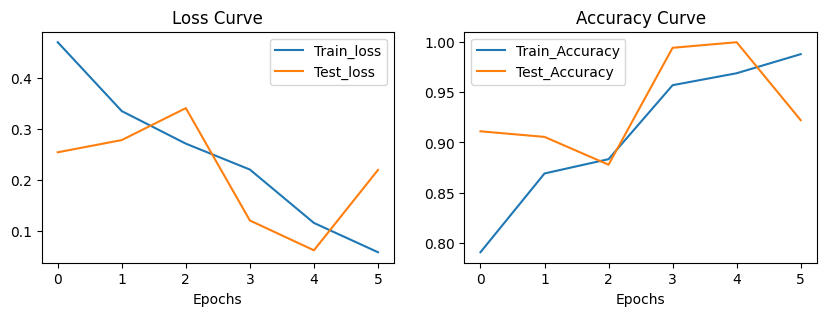

In [189]:
plot_loss_curve(model_0_result)

### Saving the Model:

In [170]:
# Save the full model
torch.save(Model_0, "siamese_model_full_final.pth")
print("Full model saved successfully!")

Full model saved successfully!


In [176]:
Model_full = torch.load("siamese_model_full_final.pth", map_location="cpu", weights_only=False)
Model_full.eval()

SiameseNetwork(
  (base_model): ModelSaimese(
    (Conv_Block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(10, 10), stride=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
      (7): ReLU(inplace=True)
      (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
      (10): ReLU(inplace=True)
    )
    (Classifier): Sequential(
      (0): Linear(in_features=9216, out_features=4096, bias=True)
      (1): Sigmoid()
    )
  )
  (l1_distance): L1Dist()
  (classifier): Sequential(
    (0): Linear(in_features=4096, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

# Predictions:

In [177]:
def PredictionSiamese(model: torch.nn.Module,
                      data: list,
                      device: torch.device = device):
    pred_probs = []
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for (sample1, sample2) in data:
            sample1 = torch.unsqueeze(sample1, dim=0).to(device)
            sample2 = torch.unsqueeze(sample2, dim=0).to(device)
            y_pred = model(sample1, sample2)  
            
            pred_prob = y_pred.squeeze()
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [178]:
random.seed(42)

test_list = list(test_dataset)
sampled_pairs = random.sample(test_list, k=100)

pairs = []
pair_labels = []

for sample1, sample2, label in sampled_pairs:
    pairs.append((sample1, sample2))
    pair_labels.append(label)

print(f"Example label: {pair_labels[0]}")
print(f"Example pair shapes: {pairs[0][0].shape}, {pairs[0][1].shape}")

Example label: 1.0
Example pair shapes: torch.Size([3, 105, 105]), torch.Size([3, 105, 105])


In [183]:
pairs_only = [(s1, s2) for s1, s2, label in sampled_pairs]
pred_probs = PredictionSiamese(model=Model_full, data=pairs_only)
print(pred_probs)

tensor([0.5819, 0.0726, 0.8932, 0.7414, 0.1194, 0.4385, 0.8884, 0.8519, 0.0105,
        0.9183, 0.0324, 0.9153, 0.3427, 0.0122, 0.8415, 0.0752, 0.2104, 0.5281,
        0.0103, 0.0648, 0.9126, 0.0509, 0.9220, 0.7463, 0.9926, 0.0871, 0.0083,
        0.0036, 0.0550, 0.9464, 0.8413, 0.9605, 0.8527, 0.7177, 0.0512, 0.9622,
        0.9480, 0.7461, 0.5591, 0.0052, 0.3678, 0.7547, 0.6342, 0.0055, 0.6091,
        0.7038, 0.0042, 0.0614, 0.9411, 0.6072, 0.7661, 0.0050, 0.0075, 0.9622,
        0.0689, 0.0295, 0.4302, 0.2657, 0.6559, 0.6488, 0.0473, 0.8241, 0.2202,
        0.0515, 0.3971, 0.0028, 0.6856, 0.0013, 0.7839, 0.0015, 0.6606, 0.0075,
        0.8881, 0.8769, 0.8332, 0.0113, 0.8065, 0.3055, 0.3216, 0.2271, 0.6844,
        0.4343, 0.0308, 0.0275, 0.3949, 0.8501, 0.7147, 0.8827, 0.0133, 0.5255,
        0.6300, 0.0023, 0.0060, 0.5696, 0.4558, 0.0029, 0.0340, 0.7474, 0.9911,
        0.9346])


In [184]:
test_labels=torch.tensor(pair_labels)
test_labels

tensor([1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1.])

In [185]:
pred_labels = (pred_probs > 0.5).float()  
print(pred_labels)

tensor([1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 1.,
        0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 0., 0., 1.,
        0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0.,
        1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 0., 0., 1., 1., 1.])


In [186]:
count=0
index=[]
for i in range(len(test_labels)):
    if test_labels[i]==pred_labels[i]:
        count=count+1
    if test_labels[i]!=pred_labels[i]:
        index.append(i)
print(f"Total Photos : {len(test_labels)}")
print(f"Correctly predicted : {count}")
print(f"False Prediction Photos index: {index}")

Total Photos : 100
Correctly predicted : 93
False Prediction Photos index: [5, 56, 77, 78, 79, 81, 84]


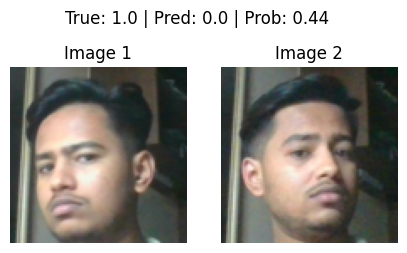

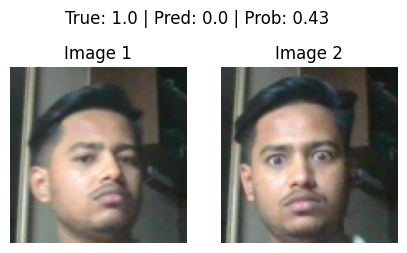

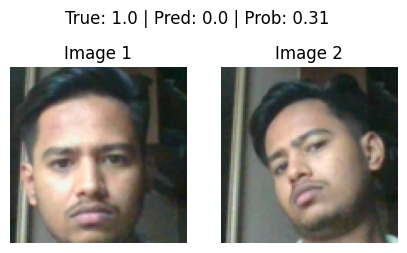

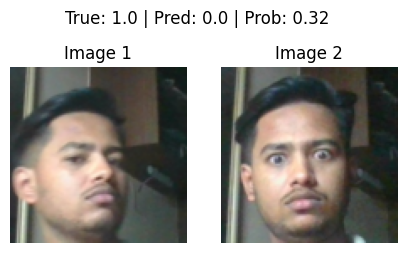

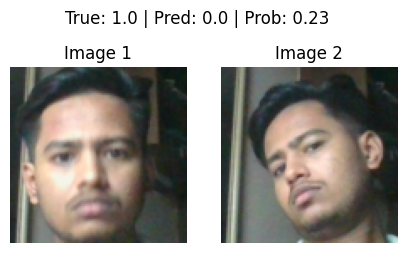

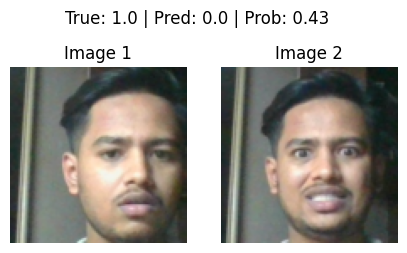

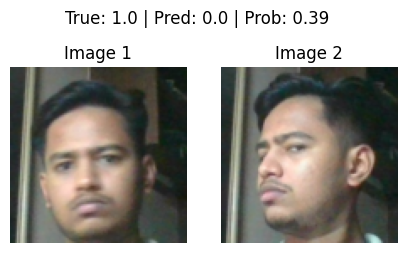

In [187]:
# Visualize incorrect predictions
wrong_indices = [5, 56, 77, 78, 79, 81, 84]

for idx in wrong_indices:
    img1, img2, true_label = sampled_pairs[idx]
    img1_np = img1.permute(1, 2, 0).cpu().numpy()
    img2_np = img2.permute(1, 2, 0).cpu().numpy()
    
    pred_prob = pred_probs[idx].item()
    pred_label = pred_labels[idx].item()

    plt.figure(figsize=(5, 3))
    
    # First image
    plt.subplot(1, 2, 1)
    plt.imshow(img1_np)
    plt.axis('off')
    plt.title("Image 1")
    
    # Second image
    plt.subplot(1, 2, 2)
    plt.imshow(img2_np)
    plt.axis('off')
    plt.title("Image 2")
    
    plt.suptitle(f"True: {true_label} | Pred: {pred_label} | Prob: {pred_prob:.2f}")
    plt.show()


In [188]:
# Calculate Recall
recall = recall_score(test_labels,pred_labels, average='macro')  # macro for all classes equally
print(f"Test Recall: {recall:.4f}")

Test Recall: 0.9386


In [190]:
summary(Model_full,input_data=(torch.randn(1,3,105,105), torch.randn(1,3,105,105)))

Layer (type:depth-idx)                   Output Shape              Param #
SiameseNetwork                           [1, 1]                    --
├─ModelSaimese: 1-1                      --                        --
│    └─Sequential: 2-1                   [1, 256, 6, 6]            --
│    │    └─Conv2d: 3-1                  [1, 64, 96, 96]           19,264
│    │    └─ReLU: 3-2                    [1, 64, 96, 96]           --
│    │    └─MaxPool2d: 3-3               [1, 64, 48, 48]           --
│    │    └─Conv2d: 3-4                  [1, 128, 42, 42]          401,536
│    │    └─ReLU: 3-5                    [1, 128, 42, 42]          --
│    │    └─MaxPool2d: 3-6               [1, 128, 21, 21]          --
│    │    └─Conv2d: 3-7                  [1, 128, 18, 18]          262,272
│    │    └─ReLU: 3-8                    [1, 128, 18, 18]          --
│    │    └─MaxPool2d: 3-9               [1, 128, 9, 9]            --
│    │    └─Conv2d: 3-10                 [1, 256, 6, 6]            524,

# Hence our Loaded Model is same as our Trained Model